<a href="https://colab.research.google.com/github/AyobamiMichael/Application-of-Kernel-based-Contrastive-Independent-Component-Analysis-KCICA-on-EEG-dataset/blob/main/Application_of_Kernel_based_Contrastive_Independent_Component_Analysis_(KCICA)_on_EEG_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

In [6]:
data_dir = "eeg_data/"
csv_files = [f for f in os.listdir(data_dir) if f.endswith(".csv")]


eeg_data = [pd.read_csv(os.path.join(data_dir, f)) for f in csv_files]


print(eeg_data[0].shape)

(30999, 19)


In [7]:

eeg_data_combined = np.stack([df.values for df in eeg_data], axis=0)
print(eeg_data_combined.shape)

(36, 30999, 19)


In [11]:
def normalize_data(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    return (data - mean) / std

eeg_data_normalized = [normalize_data(df.values) for df in eeg_data]

In [12]:
eeg_data_tensors = [torch.tensor(df, dtype=torch.float32) for df in eeg_data_normalized]

print(eeg_data_tensors[0].shape)

torch.Size([30999, 19])


In [13]:
eeg_data_combined = torch.cat(eeg_data_tensors, dim=0)

dataset = TensorDataset(eeg_data_combined)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [14]:
def rbf_kernel(x, sigma=1.0):

    pairwise_sq_dists = torch.cdist(x, x, p=2) ** 2
    return torch.exp(-pairwise_sq_dists / (2 * sigma ** 2))

def hsic_loss(X, Y):
    n = X.size(0)
    K = rbf_kernel(X)
    L = rbf_kernel(Y)
    H = torch.eye(n) - (1/n) * torch.ones((n, n))
    H = H.to(X.device)
    HSIC = torch.trace(K @ H @ L @ H) / (n - 1) ** 2
    return HSIC

In [15]:
class KCICA(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128):
        super(KCICA, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.encoder(x)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


input_dim = 19
output_dim = 19
model = KCICA(input_dim=input_dim, output_dim=output_dim).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01)

In [17]:
patience = 10
best_loss = float("inf")
counter = 0


num_epochs = 1000
for epoch in range(num_epochs):
    for batch in dataloader:
        X = batch[0].to(device)


        neg_samples = X[torch.randperm(X.size(0))]


        optimizer.zero_grad()
        S = model(X)


        loss = hsic_loss(S, S) - hsic_loss(S, neg_samples)


        loss.backward()
        optimizer.step()


    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


    if loss.item() < best_loss:
        best_loss = loss.item()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

print("Training Complete!")

Epoch 0, Loss: -0.0009
Early stopping at epoch 12
Training Complete!


In [18]:
subject_data = eeg_data_tensors[0].to(device)
recovered_sources = model(subject_data).detach().cpu().numpy()

print(recovered_sources.shape)

(30999, 19)


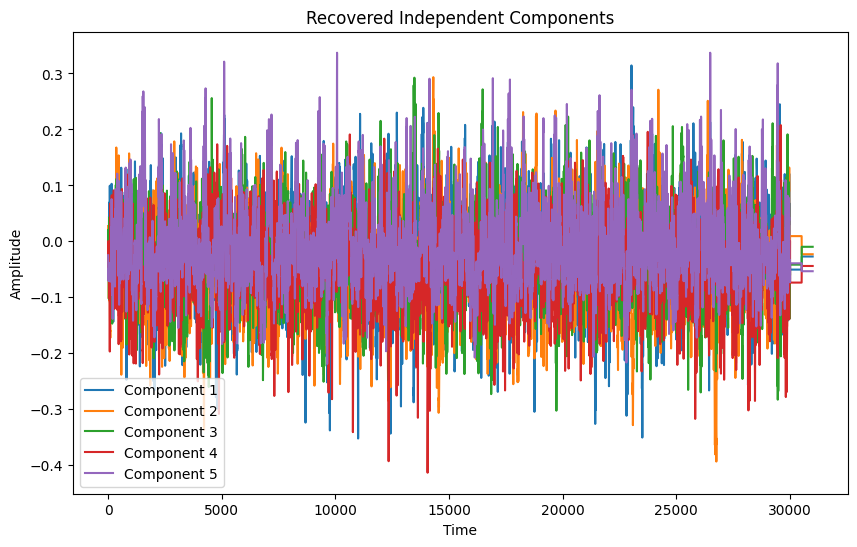

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot(recovered_sources[:, i], label=f"Component {i+1}")
plt.legend()
plt.title("Recovered Independent Components")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [17]:
torch.save(model.state_dict(), "kcica_eeg_model.pth")

In [18]:
model = KCICA(input_dim=input_dim, output_dim=output_dim).to(device)
model.load_state_dict(torch.load("kcica_eeg_model.pth"))
model.eval()

<ipython-input-18-6be88cf35654>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("kcica_eeg_model.pth"))


KCICA(
  (encoder): Sequential(
    (0): Linear(in_features=19, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=19, bias=True)
  )
)